In [2]:
import os
import pickle
import glob
import skimage
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import shutil, os

import sys

sys.path.append('../functions')

import chirp_functions as proc
%matplotlib inline

### Preprocessing

In [3]:
# filter out cavities that are too far from the transducer
raw_dir = '../../data/kagome-02.26.2022-center/raw/band_structure/'
dest_dir = '../../data/kagome-02.26.2022-center/raw/band_structure_small/'
onlyfiles = [f for f in listdir(raw_dir) if (isfile(join(raw_dir, f)) and f != '.DS_Store')]

counter = 0


for fn in onlyfiles:
    x = float((fn.split('.')[0]).split('_')[-2])
    y = float((fn.split('.')[0]).split('_')[-1])

    x_unit = 10 * np.sqrt(3)/4
    y_unit = 10 * 3/4

    dist = np.sqrt((x*x_unit)**2 + (y*y_unit)**2)

    if dist <= 100:
        shutil.copy(raw_dir+fn, dest_dir)
        counter += 1

print('Raw files:', len(onlyfiles))
print('Copied', counter, 'files')




Raw files: 185
Copied 70 files


In [4]:
# preprocess
proc.preprocess_chirp(data_dir = dest_dir, 
                       frequencies = np.linspace(1000.0, 18000.0, 426), 
                       targetfile = '../../data/kagome-02.26.2022-center/preprocessed_band/', 
                       title = 'scppos_', setno = 0)



Found 70 records
Preprocessing complete!


### Sweep visualization

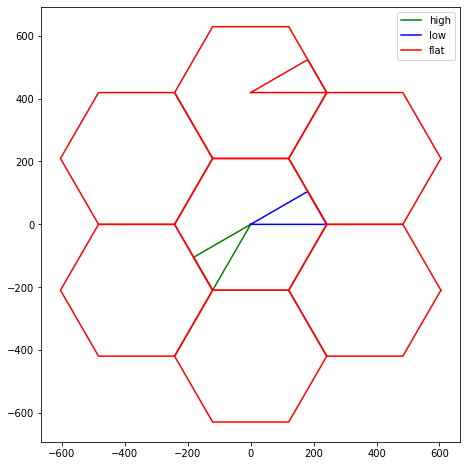

In [5]:
# visualizing the 3 sweeps in reciprocal space

from tqdm import tqdm
import csv



#freqs = np.array([(0, np.array(list(np.linspace(1,16,76))+list(np.linspace(16,17, 51))+list(np.linspace(17,18,6))))], dtype=object)
freq_num = 426
freq_min = 1000.0
freq_max = 18000.0
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)

freq_div1 = 9000
freq_div2 = 130000

#L_kag = 0.008
#L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)

b_res = 50
b = np.linspace(0, 1.5+np.sqrt(3)/2, b_res) #GKMG sweep parameter

kxb_low = np.zeros(len(b))
kyb_low = np.zeros(len(b))
kxb_high = np.zeros(len(b))
kyb_high = np.zeros(len(b))
kxb_flat = np.zeros(len(b))
kyb_flat = np.zeros(len(b))


for i in range(len(b)):
    if b[i] < 1:   
        
        #kxb_low[i] = b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        #kyb_low[i] = b[i] * 2 * np.pi / (3 * L)
        

        
        kxb_high[i] = -b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        kyb_high[i] = 4 * np.pi / (3 * L) - b[i] * 2 * np.pi / (3 * L)
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) * b[i]
        kyb_flat[i] = 4 * np.pi / (3 * L) 
        
        kxb_low[i] = kxb_flat[i]
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = kxb_high[i]
        kyb_high[i] = kyb_high[i] - 2*kymax
        
    elif b[i] < 1.5: 
        #kxb_low[i] = 2 * np.pi / (np.sqrt(3)*3 * L) - 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        #kyb_low[i] = 2 * np.pi / (3 * L) 
        kxb_high[i] = -2 * np.pi / (np.sqrt(3)*3 * L) + 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_high[i] = 2 * np.pi / (3 * L) 
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) - 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_flat[i] = 4 * np.pi / (3*L) + 2 * np.pi / (3 * L) * (b[i]-1)
        
        kxb_low[i] = kxb_flat[i] 
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = kxb_low[i] - 1.5*kxmax
        kyb_high[i] = kyb_low[i] - kymax
    else:
        #kxb_low[i] = 0
        #kyb_low[i] = 2 * np.pi / (3 * L) - 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_high[i] = 0
        kyb_high[i] = 2 * np.pi / (3 * L) + 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_flat[i] = (1- (b[i] - 1.5) * 2 / np.sqrt(3)) * np.pi / (np.sqrt(3) * L)
        kyb_flat[i] = 4 * np.pi / (3*L) + (1- 2 / (np.sqrt(3)) * (b[i]-1.5)) * np.pi / (3 * L)
        
        kxb_low[i] = kxb_flat[i]
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = -kxb_low[i] 
        kyb_high[i] = -kyb_low[i] 



plt.figure(figsize=(8,8))
#plt.plot(kxb_flat, kyb_flat, 'm-',label='flat')
plt.plot(kxb_high, kyb_high, 'g-',label='high')
plt.plot(kxb_low, kyb_low, 'b-',label='low')
plt.plot(kxb_flat, kyb_flat, 'r-',label='flat')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]


for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


### Fourier transform


Shift the Fourier transformed function in reciprocal space by 4 different reciprocal lattice vectors and summed them up to make sure the key features stay within the first Brillouin zone. 

In [6]:
filename = '../../data/kagome-02.26.2022-center/preprocessed_band/'

reciprocal_data = np.zeros((freq_num, b_res))
x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000

G = [[0.0, 0.0], [6*np.pi/(3*np.sqrt(3) * L), 2*np.pi/(3*L)], [6*np.pi/(3*np.sqrt(3) * L), -2*np.pi/(3*L)], [0, 4*np.pi/(3*L)]]
    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f) 
            
            if values[j] <= freq_div1:
                
                for i in range(b_res):
                    for k_no in range(4):
                        k_current = [kxb_low[i] + G[k_no][0], kyb_low[i] + G[k_no][1]]
                        amplitude = np.abs(np.array(
                                [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                    for point in real_data]).sum())
                        reciprocal_data[j][i] += amplitude
                        
            else:
                for i in range(b_res):
                    for k_no in range(4):
                        k_current = [kxb_high[i] + G[k_no][0], kyb_high[i] + G[k_no][1]]
                        amplitude = np.abs(np.array(
                                [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                    for point in real_data]).sum())
                        reciprocal_data[j][i] += amplitude
 

            

reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]

100%|██████████| 426/426 [00:47<00:00,  8.97it/s]


/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error in 3.6


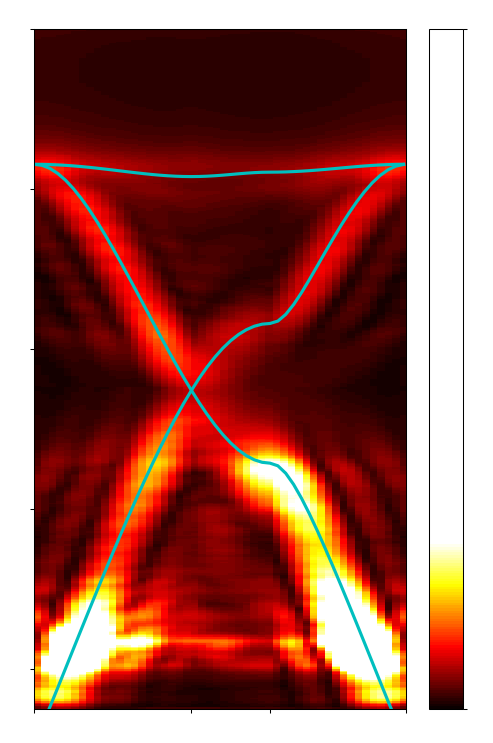

In [13]:
#print(np.max(reciprocal_data_plot))

#reciprocal_data_plot = (reciprocal_data-np.min(reciprocal_data))/(np.max(reciprocal_data)-reciprocal_data)
reciprocal_data_plot = reciprocal_data/np.max(reciprocal_data)


from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import matplotlib.cm as cm


folder = '../../data/kagome-02.26.2022-center/'

b_sim = []
band1 = []
band2 = []
band3 = []


with open('../../data/simulation/kagome_machine_bands_clean.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        b_sim.append(float(row[0]))
        band1.append(float(row[1]))
        band2.append(float(row[2]))
        band3.append(float(row[3]))

        
hot = cm.get_cmap('hot', 256)
hotnew = hot(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
hotnew[63:, :] = white
hotnew[:63, :] = hot(np.linspace(0, 1, 63))
newcmp = ListedColormap(hotnew)


# GKMG sweep
plt.figure(figsize = (2, 3), dpi = 300)
freq = np.linspace(1000.0, 18000.0, 426)
min_index = np.where(freq == 1000.0)[0][0]
max_index = len(reciprocal_data)
plt.imshow(reciprocal_data_plot[np.linspace(min_index, max_index-1,max_index-min_index-1).astype(int)], cmap = newcmp, vmin = 0.0, vmax = 1.0, extent = [b[0], b[-1], 1.0, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, linestyle = '-', color = "c", linewidth = 0.75)
plt.plot(b_sim, band2, linestyle = '-', color = "c", linewidth = 0.75)
plt.plot(b_sim, band3, linestyle = '-', color = "c", linewidth = 0.75)
plt.axis([b[0], b[-1], 1, 18])
cb = plt.colorbar(ticks = [0, 1])
cb.ax.set_yticklabels(['',''])
cb.ax.yaxis.set_tick_params(width=0.25, length = 1)
plt.yticks(np.linspace(2, 18, 5), fontsize = 20)



plt.xticks([0, 1, 1.5, b[-1]], fontsize=25)
ax = plt.gca()

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.25)

ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)
cb.outline.set_linewidth(0.25)

ax.xaxis.set_tick_params(width=0.25, length = 1)
ax.yaxis.set_tick_params(width=0.25, length = 1)
plt.savefig('../../paper/figure2/band-structure.pdf', interpolation='none')



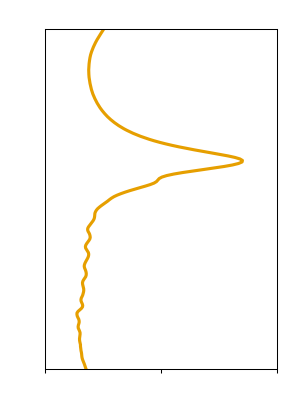

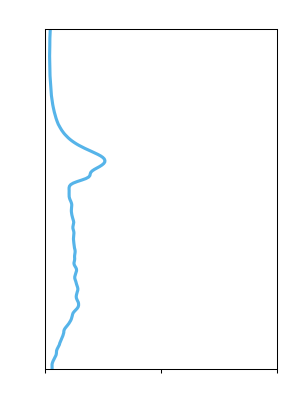

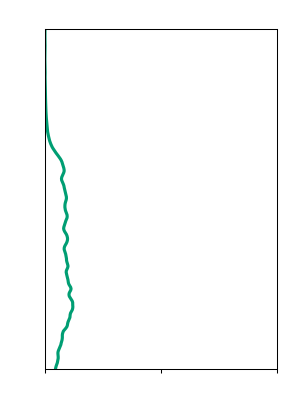

In [8]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from os import listdir
from os.path import isfile, join

fns = ['scppos_1_1', 'scppos_3_3', 'scppos_5_5']
color = ['#E69F00', '#56B4E9','#009E73']
datadir = '../../data/kagome-02.26.2022-center/raw/real_space/'
outdir = '../../paper/figure2/'

preamp_gain = 4.731513 
mic_gain = 0.02 #0.02V/Pa 

for i, fn in enumerate(fns):
    filepath = datadir+fn+'.pkl'
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
        freq = data[:,0]
        amplitude = data[:,1]
    
    amplitude /= preamp_gain*mic_gain
    

    min_index = np.where(freq == 8000.0)[0][0]
    max_index = np.where(freq == 18000.0)[0][0]
    num = max_index-min_index+1
    plt.figure(figsize=(1,1.5), dpi=300)
    plt.plot(amplitude[np.linspace(min_index,max_index,num).astype(int)],freq[np.linspace(min_index,max_index,num).astype(int)]/1000, color = color[i], linestyle = '-', linewidth = 0.75)
    plt.axis([0, 4, 9, 18])
    plt.xticks(np.linspace(0, 4, 3), ['','',''])
    plt.yticks([])

    ax = plt.gca()

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.25)

    ax.tick_params(labelbottom=False)
    ax.tick_params(labelleft=False)
    ax.xaxis.set_tick_params(width=0.25, length = 1)

    plt.savefig(outdir+'response_'+fn.split('_')[-1]+'-'+fn.split('_')[-2]+'.pdf')



14
425
326


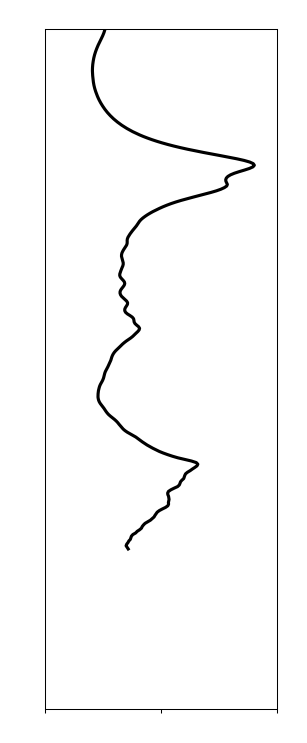

In [9]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from os import listdir
from os.path import isfile, join
mypath = '../../data/kagome-02.26.2022-center/raw/avg/'
onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f != '.DS_Store')]

print(len(onlyfiles))

for i, file in enumerate(onlyfiles):
    with open(join(mypath, file), 'rb') as f:
        data = pickle.load(f)
        if i == 0:
            freq = data[:,0]
            amplitude = data[:,1]
        else:
            amplitude += data[:,1]
        
amplitude /= len(onlyfiles)

preamp_gain = 4.731513 
mic_gain = 0.02 #0.02V/Pa 

amplitude /= preamp_gain*mic_gain


min_index = np.where(freq == 5000.0)[0][0]
max_index = np.where(freq == 18000.0)[0][0]
print(max_index)
num = max_index-min_index+1
print(num)
plt.figure(figsize=(1,3), dpi=300)
plt.plot(amplitude[np.linspace(min_index,max_index,num).astype(int)],freq[np.linspace(min_index,max_index,num).astype(int)]/1000, 'k', linewidth = 0.75)
plt.axis([0, 2, 1, 18])
plt.xticks(np.linspace(0, 2, 3))
plt.yticks([])


ax = plt.gca()

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.25)

ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)
ax.xaxis.set_tick_params(width=0.25, length = 1)


plt.savefig("../../paper/figure2/avg-response.pdf")

